<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install py_pcha
!pip install gsw

Grab the data

In [10]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-05-13 21:22:28--  https://docs.google.com/uc?export=download&confirm=kc1F&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 108.177.12.113, 108.177.12.139, 108.177.12.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-ao-docs.googleusercontent.com/docs/securesc/a587b0bcaptnmepdi82pfccnkoo4bo4g/gur1nvhu070v0f8k3sbqgl1l3mb533i9/1620940875000/06203730782251856755/11865786986701176214Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-05-13 21:22:28--  https://doc-00-ao-docs.googleusercontent.com/docs/securesc/a587b0bcaptnmepdi82pfccnkoo4bo4g/gur1nvhu070v0f8k3sbqgl1l3mb533i9/1620940875000/06203730782251856755/11865786986701176214Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-00-ao-docs.googleusercontent.com (doc-00-ao-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connectin

In [11]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [17]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temp'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temp"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temp"])

In [20]:
#ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
#                          "silicate", "NO", "PO"]
ARCH_ANALYSIS_FEATURES = ["conservative_temp", "absolute_salinity",
                          "silicate", "nitrate", "phosphate", "oxygen"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES+["latitude", "longitude"]

#feature_weights = {"conservative_temp": 56.0,
#                   "absolute_salinity": 80.0,
#                   "silicate": 3.0,
#                   "NO": 5.0,
#                   "PO": 5.0}

#Weight all features equally for now...
feature_weights = {"conservative_temp": 1.0,
                   "absolute_salinity": 1.0,
                   "silicate": 1.0,
                   "NO": 1.0,
                   "PO": 1.0,
                   "nitrate": 1.0,
                   "phosphate": 1.0,
                   "oxygen": 1.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                          0.0
longitude                         0.0
year                              0.0
depth                             0.0
pressure                          0.0
temperature                       0.0
salinity                          0.0
oxygen                            0.0
silicate                          0.0
nitrate                           0.0
phosphate                         0.0
sigma0                            0.0
NO                                0.0
PO                                0.0
potential_temp                    0.0
absolute_salinity                 0.0
conservative_temp                 0.0
sigma2                            0.0
sigma4                            0.0
standardized_conservative_temp    0.0
standardized_absolute_salinity    0.0
standardized_silicate             0.0
standardized_nitrate              0.0
standardized_phosphate            0.0
standardized_oxygen         

On water mass AABW
Ranges: {'lat_min': -60.0, 'lat_max': -50.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 46.04, 'sig4_max': 200}


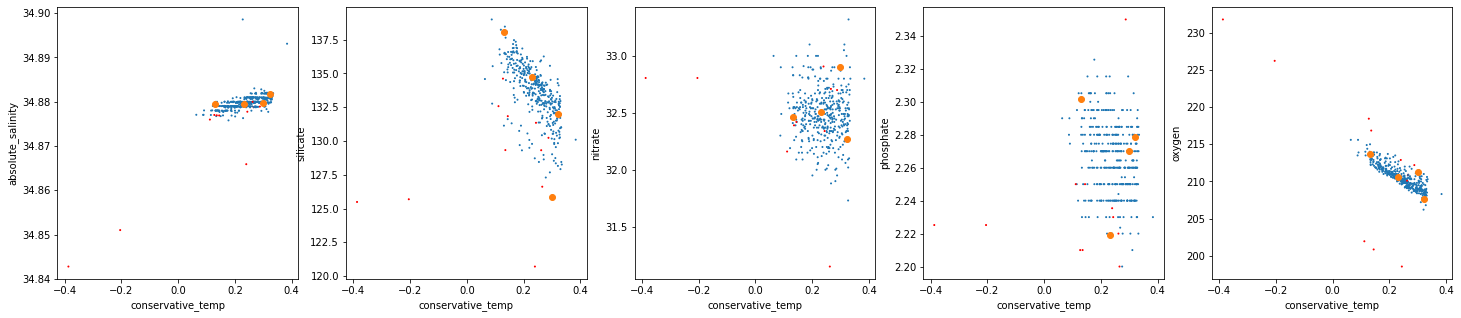

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,0.130685,34.879505,138.083375,32.464778,2.301754,213.656639,-59.464327,-86.577525,AABW_0
1,0.299621,34.879749,125.860000,32.900000,2.270000,211.300000,-59.751000,-103.000000,AABW_1
2,0.231253,34.879472,134.747762,32.507662,2.218967,210.536506,-53.607410,-93.653763,AABW_2
3,0.321856,34.881815,131.986817,32.271103,2.278575,207.635211,-52.523609,-85.826312,AABW_3


On water mass AAIW
Ranges: {'lat_min': -51.0, 'lat_max': -47.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig0_min': 27.01, 'sig0_max': 27.1}


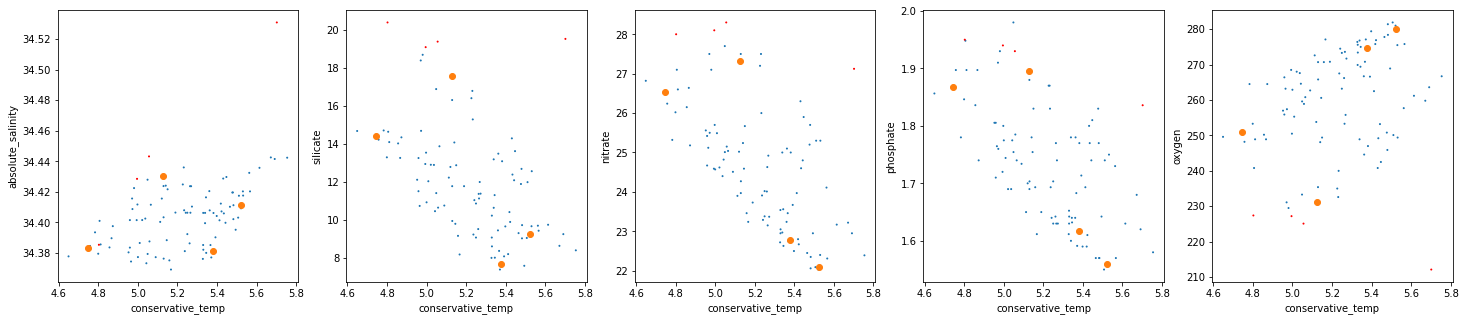

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,5.522628,34.411082,9.258578,22.103189,1.559607,279.982499,-48.679071,-88.013918,AAIW_0
1,5.126499,34.430309,17.595861,27.332450,1.895132,231.301490,-49.178299,-102.999581,AAIW_1
2,5.378564,34.381037,7.679766,22.774739,1.617767,274.825565,-50.009514,-88.492628,AAIW_2
3,4.745625,34.383534,14.407089,26.530278,1.867316,251.053559,-48.969946,-88.049448,AAIW_3


On water mass ESSW
Ranges: {'lat_min': -5, 'lat_max': 5, 'lon_min': -90.0, 'lon_max': -80.0, 'sig0_min': 26.0, 'sig0_max': 27.0}


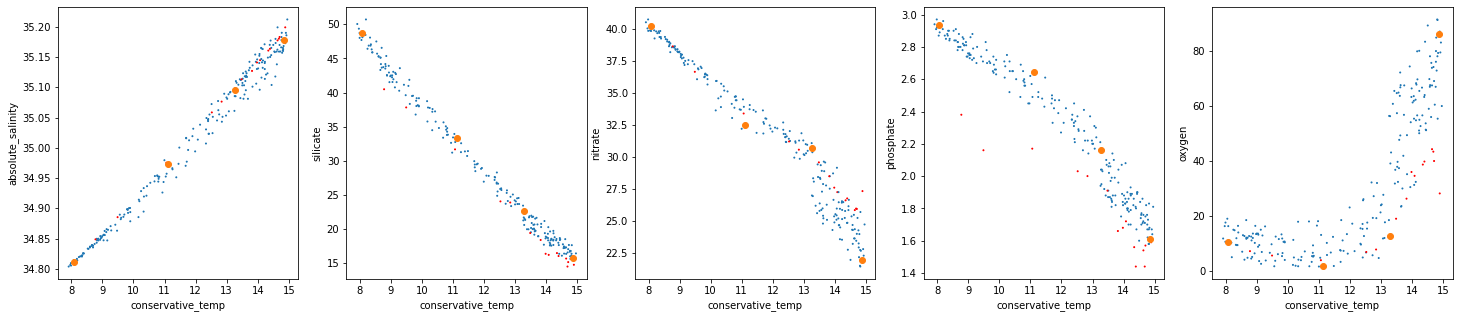

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,8.075272,34.811417,48.715103,40.256369,2.933025,10.629886,1.836001,-86.258368,ESSW_0
1,13.271765,35.094756,22.679899,30.712755,2.162235,12.623345,-2.971641,-83.811312,ESSW_1
2,11.120324,34.973239,33.343202,32.481001,2.642428,1.859919,-2.475157,-85.958948,ESSW_2
3,14.855507,35.178504,15.728141,21.987631,1.611875,86.172797,-1.506125,-85.832276,ESSW_3


On water mass LCDW
Ranges: {'lat_min': -64.0, 'lat_max': -58.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig4_min': 45.84, 'sig4_max': 46.04}


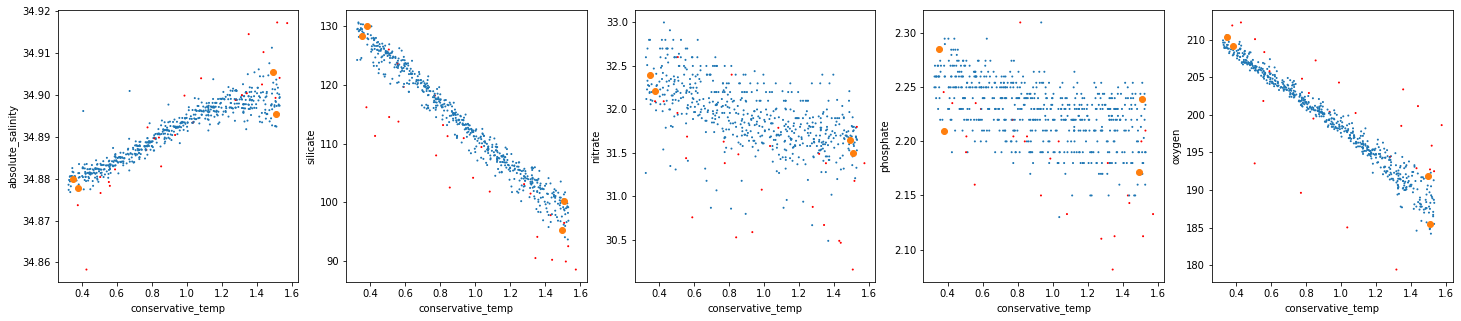

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.508196,34.895537,100.277379,31.504852,2.239290,185.506487,-59.387310,-79.498728,LCDW_0
1,0.349377,34.879958,128.384555,32.399218,2.285577,210.294350,-61.339619,-88.341071,LCDW_1
2,1.493033,34.905464,95.386727,31.646338,2.171465,191.929297,-60.972849,-102.985876,LCDW_2
3,0.378828,34.877665,130.024185,32.206948,2.209616,209.094242,-60.581679,-102.950768,LCDW_3


On water mass NPIW
Ranges: {'lat_min': 36.0, 'lat_max': 40.0, 'lon_min': 150.0, 'lon_max': 170.0, 'sig0_min': 26.6, 'sig0_max': 27.0, 'ox_min': 0, 'ox_max': 150.0}


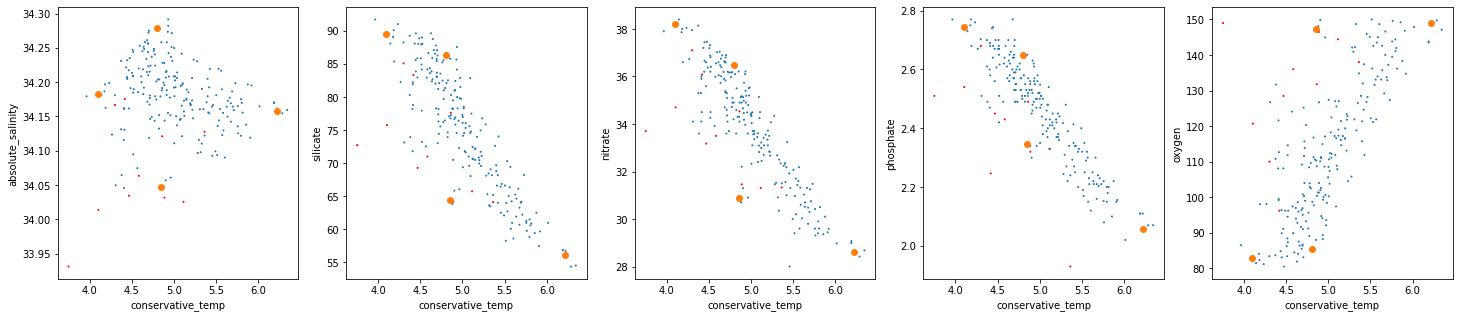

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,4.852294,34.047532,64.495751,30.891432,2.346881,147.233977,39.350399,155.000000,NPIW_0
1,4.801202,34.279357,86.297150,36.485987,2.647905,85.455478,36.905912,157.756800,NPIW_1
2,6.220370,34.157712,56.162679,28.591640,2.056679,148.987518,38.852462,168.020634,NPIW_2
3,4.096139,34.182601,89.493159,38.209868,2.745412,83.016913,39.380052,161.902677,NPIW_3


On water mass PDW1
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig0_min': 27.6, 'sig0_max': 200, 'sig2_min': 0, 'sig2_max': 36.96}


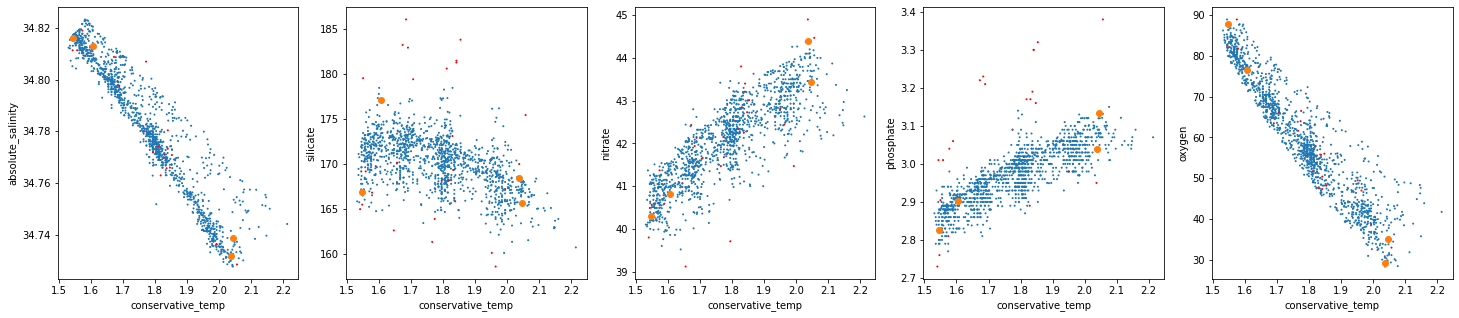

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,2.045641,34.738780,165.705015,43.436344,3.135189,35.197899,41.252989,-157.145605,PDW1_0
1,1.606052,34.812841,177.071074,40.805847,2.903102,76.436085,45.571986,-140.968240,PDW1_1
2,2.037144,34.731860,168.400000,44.400000,3.040000,29.300000,42.003000,-164.990000,PDW1_2
3,1.545799,34.816152,166.868568,40.313370,2.826661,87.665067,47.000069,-167.311841,PDW1_3


On water mass PDW2-3
Ranges: {'lat_min': 39.0, 'lat_max': 51.0, 'lon_min': -170.0, 'lon_max': -133.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.88}


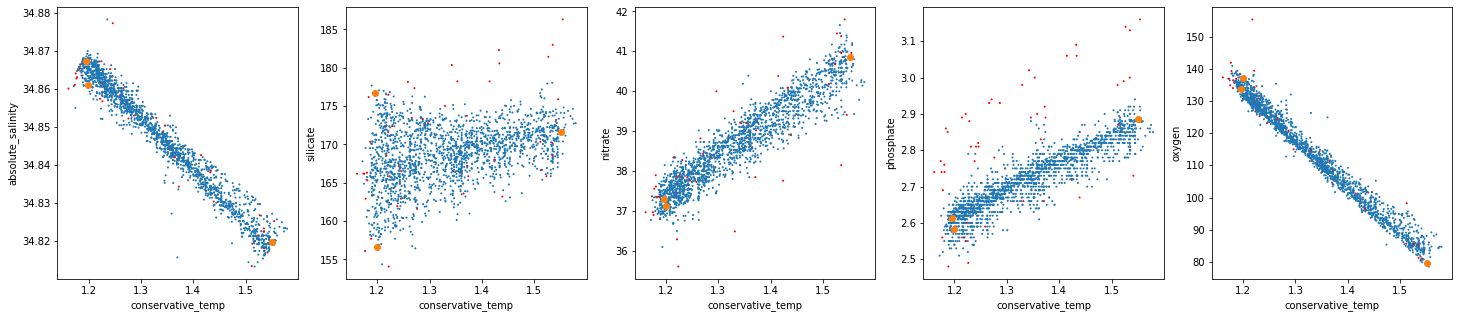

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.551107,34.819677,171.673937,40.846997,2.885426,79.808398,45.543353,-153.364219,PDW2-3_0
1,1.195652,34.867234,176.650247,37.308985,2.614496,133.590836,47.136792,-135.892173,PDW2-3_1
2,1.199783,34.861051,156.585745,37.115814,2.582515,137.228603,45.858580,-167.654104,PDW2-3_2


On water mass PSUW
Ranges: {'lat_min': 50, 'lat_max': 58, 'lon_min': -155, 'lon_max': -140, 'sig0_min': 25.0, 'sig0_max': 25.6}


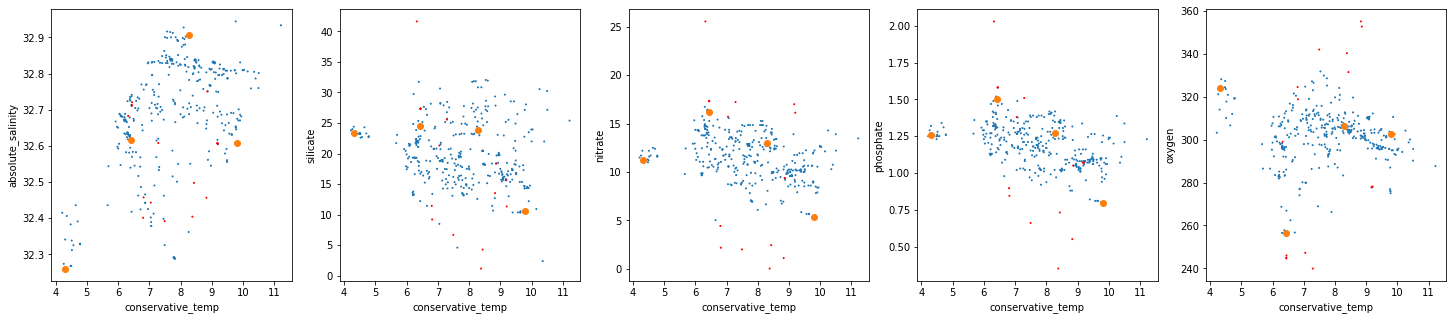

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,6.429571,32.616153,24.566223,16.217104,1.504519,256.507450,56.305086,-152.940210,PSUW_0
1,4.313754,32.260443,23.400000,11.200000,1.260000,324.210000,56.220000,-153.190000,PSUW_1
2,8.282132,32.905680,23.912544,13.004870,1.273839,306.213233,51.031066,-148.691915,PSUW_2
3,9.801862,32.607685,10.656246,5.336080,0.793134,302.655449,57.421555,-145.064028,PSUW_3


On water mass UCDW
Ranges: {'lat_min': -50.0, 'lat_max': -45.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig2_min': 36.96, 'sig2_max': 200, 'sig4_min': 0, 'sig4_max': 45.84}


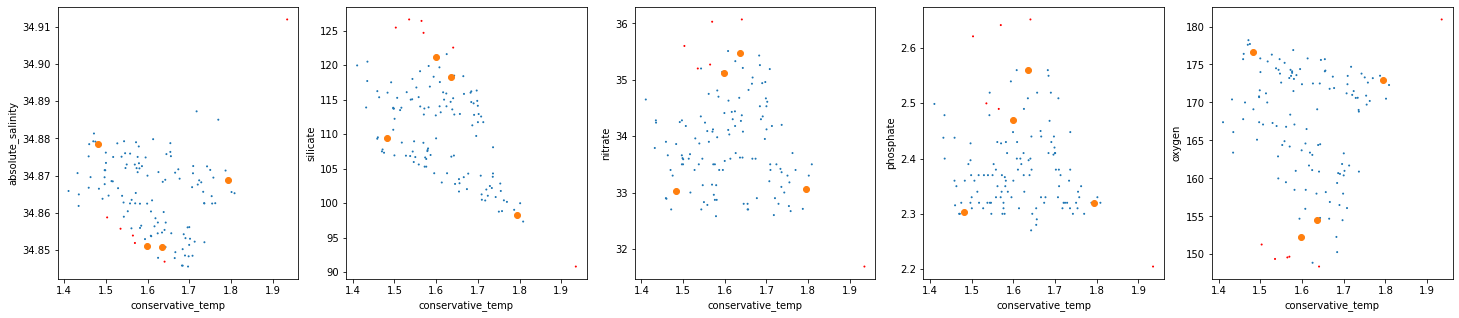

,conservative_temp,absolute_salinity,silicate,nitrate,phosphate,oxygen,latitude,longitude,watermass_name
0,1.794154,34.868840,98.347954,33.057667,2.319250,173.023679,-49.249622,-102.999985,UCDW_0
1,1.598663,34.851092,121.213435,35.128776,2.470323,152.325525,-45.541356,-77.181906,UCDW_1
2,1.481922,34.878450,109.421720,33.024344,2.303644,176.669388,-48.864987,-97.531434,UCDW_2
3,1.635352,34.850952,118.366777,35.475422,2.559890,154.579119,-46.273033,-80.857652,UCDW_3


In [21]:
from py_pcha import PCHA
import scipy 
from scipy import spatial
from IPython.display import display, HTML


def flag_outliers(features, n_neighbors=20, zscore_threshold=2):
    #Features is observations X features
    #Do a process of removing outliers; if the average distance of a point to
    # its nearest N neighbors is more than stdev number of standard deviations from
    # the mean, flag it as an outlier.
    #I tried the Extreme Studentized Deviate but it wasn't behaving very
    # predictably. I guess the distribution of neighbor distances is
    # exponential-ish rather than normal.
    pairwise_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(X=features, metric="euclidean"))
    avg_dist_to_nn = np.mean(
        np.sort(pairwise_distances, axis=-1)[:,1:n_neighbors+1], axis=-1)
    zscore_avgdisttonn = (avg_dist_to_nn - np.mean(avg_dist_to_nn))/np.std(
                          avg_dist_to_nn)
    #plt.hist(zscore_avgdisttonn, bins=100)
    #plt.show()
    anomalous_indices = np.abs(zscore_avgdisttonn) > zscore_threshold
    return anomalous_indices


def run_archetype_analysis(df, num_endmembers):
    np.random.seed(1234) #fix seed for reproducibility of results
    all_features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    all_origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    outliers = flag_outliers(all_features)
    features = all_features[outliers==False]
    origspace_features = all_origspace_features[outliers==False]

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(25,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(all_origspace_features[:,featureidx1],
                            all_origspace_features[:,featureidx2],
                            c=[("red" if x==True else "C0") for x in outliers],
                            s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2],
                            color="C1")
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

#num_archetypes is not really a filter condition but this is the easiest
# place to store that feature
filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1,
             "num_archetypes":4},
    "NPIW": {"lat_min":36.0, "lat_max":40.0, 
             "lon_min":150.0, "lon_max":170.0,
             "sig0_min":26.6, "sig0_max":27.0,
             "ox_min":0, "ox_max":150.0,
             "num_archetypes":4},
    "UCDW": {"lat_min":-50.0, "lat_max":-45.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.84,
             "num_archetypes":4},
    "LCDW": {"lat_min":-64.0, "lat_max":-58.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":45.84, "sig4_max":46.04,
             "num_archetypes":4},
    "AABW": {"lat_min":-60.0, "lat_max":-50.0, 
             "lon_min":-120.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             "num_archetypes":4},
    "PDW1": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig2_min":0, "sig2_max":36.96,
             'num_archetypes':4},
    "PDW2-3": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig2_min":36.96, "sig2_max":200,
             "sig4_min":0, "sig4_max":45.88,
             "num_archetypes":3},
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.0, "sig0_max": 27.0,
             "num_archetypes":4},
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.0, "sig0_max": 25.6,
             "num_archetypes":4}
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max,
                sig0_min=0, sig0_max=np.inf, 
                sig2_min=0, sig2_max=np.inf,
                sig4_min=0, sig4_max=np.inf,
                ox_min=0, ox_max=np.inf):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] <= sig0_max) &
            (df["sigma2"] >= sig2_min) &
            (df["sigma2"] <= sig2_max) &
            (df["sigma4"] >= sig4_min) &
            (df["sigma4"] <= sig4_max) &
            (df["oxygen"] >= ox_min) &
            (df["oxygen"] <= ox_max) 
            ]

watermass_to_archetypes = {}

for watermass in sorted(filter_conditions.keys()):
  print("On water mass", watermass)
  num_archetypes = filter_conditions[watermass]['num_archetypes']
  del filter_conditions[watermass]['num_archetypes']
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(
      df=watermass_rows,
      num_endmembers=num_archetypes)
  watermass_archetypes["watermass_name"] = [watermass+"_"+str(i)
                                            for i in range(num_archetypes)]
  watermass_to_archetypes[watermass] = watermass_archetypes
  display(watermass_archetypes)

full_watermass_df = pandas.concat([watermass_to_archetypes[watermass]
                          for watermass in sorted(watermass_to_archetypes.keys())])

In [22]:
full_watermass_df.to_csv("GP15_intermediateanddeep_endmemberswithsubtypes.csv",
                         columns=["watermass_name"]+ALL_FEATURES_TO_AVERAGE,
                         index=False)